# Train Kuala Lumpur real estate model using Keras preprocessing layers

This notebook is an example of training a model for the Kuala Lumpur dataset is adapted from this example shared in the TensorFlow documentation https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers

In [79]:
''' check to see if the notebook is being run in Colab, and if so, set the current directory appropriately'''
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/notebooks


In [80]:
import time
start_time = time.time()

## Import libraries and configs

In [81]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# carry over imports from custom layer version
import time
import seaborn as sns
# import datetime, timedelta
import datetime
import pydotplus
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from pickle import dump
from pickle import load
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
import yaml
import math

In [82]:
tf.__version__

'2.9.2'

In [83]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

path_to_yaml = os.path.join(current_path, 'model_training_config.yml')
print("path_to_yaml "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file')


current directory is: /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/notebooks
path_to_yaml /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/notebooks/model_training_config.yml


In [84]:
# load parameters

repeatable_run = config['test_parms']['repeatable_run']
# fix seeds to get identical results on mulitiple runs
if repeatable_run:
    from numpy.random import seed
    seed(4)
    tf.random.set_seed(7)


testproportion = config['test_parms']['testproportion'] # proportion of data reserved for test set
trainproportion = config['test_parms']['trainproportion'] # proportion of non-test data dedicated to training (vs. validation)
get_test_train_acc = config['test_parms']['get_test_train_acc']
verboseout = config['general']['verboseout']
includetext = config['general']['includetext'] # switch to determine whether text columns are included in the model
save_model_plot = config['general']['save_model_plot'] # switch to determine whether to generate plot with plot_model
tensorboard_callback = config['general']['tensorboard_callback'] # switch to determine if tensorboard callback defined

presaved = config['general']['presaved']
savemodel = config['general']['savemodel']
picklemodel = config['general']['picklemodel']
hctextmax = config['general']['hctextmax']
maxwords = config['general']['maxwords']
textmax = config['general']['textmax']

targetthresh = config['general']['targetthresh']
targetcontinuous = config['general']['targetcontinuous']
target_col = config['general']['target_col']

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}



emptythresh = config['general']['emptythresh']
zero_weight = config['general']['zero_weight']
one_weight = config['general']['one_weight']
one_weight_offset = config['general']['one_weight_offset']
patience_threshold = config['general']['patience_threshold']


# modifier for saved model elements
modifier = config['general']['modifier']


# default hyperparameter values
learning_rate = config['hyperparameters']['learning_rate']
dropout_rate = config['hyperparameters']['dropout_rate']
l2_lambda = config['hyperparameters']['l2_lambda']
loss_func = config['hyperparameters']['loss_func']
output_activation = config['hyperparameters']['output_activation']
batch_size = config['hyperparameters']['batch_size']
epochs = config['hyperparameters']['epochs']

# date values
date_today = datetime.now()
print("date today",date_today)

# pickled original dataset and post-preprocessing dataset
pickled_data_file = config['general']['pickled_data_file']
pickled_dataframe = config['general']['pickled_dataframe']

# experiment parameter

current_experiment = config['test_parms']['current_experiment']

# load lists of column categories
collist = config['categorical']
textcols = config['text']
continuouscols = config['continuous']
excludefromcolist = config['excluded']

date today 2023-02-05 17:14:54.261440


## Helper functions

In [85]:
# get the paths required

def get_path():
    '''get the path for data files

    Returns:
        path: path for data files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

def get_pipeline_path():
    '''get the path for data files
    
    Returns:
        path: path for pipeline files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'pipelines'))
    return(path)

def get_model_path():
    '''get the path for data files
    
    Returns:
        path: path for model files
    '''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

In [86]:
def set_experiment_parameters(experiment_number, count_no_delay, count_delay):
    ''' set the appropriate parameters for the experiment 
    Args:
        experiment_number: filename containing config parameters
        count_no_delay: count of negative outcomes in the dataset
        count_delay: count of positive outcomes in the dataset

    Returns:
        early_stop: whether the experiment includes an early stop callback
        one_weight: weight applied to positive outcomes
        epochs: number of epochs in the experiment
        es_monitor: performance measurement tracked in callbacks
        es_mod: direction of performance being tracked in callbacks
    
    '''
    print("setting parameters for experiment ", experiment_number)
    # default settings for early stopping:
    es_monitor = "val_loss"
    es_mode = "min"
    if experiment_number == 0:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 1
    elif experiment_number == 9:
        #
        early_stop = True
        es_monitor="val_accuracy"
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        get_test_train_acc = False
        #
        epochs = 20    
    elif experiment_number == 1:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 10
    elif experiment_number == 2:
        #
        early_stop = False
        #
        one_weight = 1.0
        #
        epochs = 50
    elif experiment_number == 3:
        #
        early_stop = False
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 4:
        #
        early_stop = True
        es_monitor = "val_loss"
        es_mode = "min"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 50
    elif experiment_number == 5:
        #
        early_stop = True
        # if early stopping fails because the level of TensorFlow/Python, comment out the following
        # line and uncomment the subsequent if statement
        es_monitor="val_accuracy"
        '''
        if sys.version_info >= (3,7):
            es_monitor="val_accuracy"
        else:
            es_monitor = "val_acc"
        '''
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epochs = 100
    else:
        early_stop = True
    return(early_stop, one_weight, epochs,es_monitor,es_mode)

## Load the cleaned up dataset



In [87]:
def ingest_data(path):
    '''load list of valid routes and directions into dataframe
    Args:
        path: path for data files
    
    Returns:
        merged_data: dataframe loaded from pickle file
    '''
    file_name = os.path.join(path,config['file_names']['pickled_dataframe'])
    merged_data = pd.read_pickle(file_name)
    merged_data.head()
    return(merged_data)

In [88]:
def prep_merged_data(merged_data,target_col):
    '''add derived columns to merged_data dataframe
    Args:
        merged_data: input dataframe
        target_col: column that is the target
    
    Returns:
        merged_data: dataframe with derived columns added
    '''
    if targetcontinuous:
        merged_data['target'] = merged_data[target_col]
    else:
        print("target column is: ",target_col)
        print("median of target is: ",merged_data[target_col].median())
        merged_data['target'] = np.where(merged_data[target_col] >= merged_data[target_col].median(), 1, 0 )
    return(merged_data)

## Control cell for ingesting cleaned up dataset

In [89]:
# control cell for ingesting data

path = get_path()
print("path is",path)
# load route direction and delay data datframes
merged_data = ingest_data(path)
merged_data = prep_merged_data(merged_data,target_col)
# remove spaces from and lowercase column names (to avoid model saving issues)
merged_data.columns = merged_data.columns.str.replace(' ', '_')
merged_data.columns  = merged_data.columns.str.lower()
config['categorical'] = [x.replace(" ", "_") for x in config['categorical']]
config['continuous'] = [x.replace(" ", "_") for x in config['continuous']]
config['categorical'] = [x.lower() for x in config['categorical']]
config['continuous'] = [x.lower() for x in config['continuous']]

print("shape of pre refactored dataset", merged_data.shape)
print("zero count ",merged_data['target'].value_counts()[0])
print("one count",merged_data['target'].value_counts()[1])
print("shape of refactored dataset", merged_data.shape)
count_no_delay = merged_data[merged_data['target']==0].shape[0]
count_delay = merged_data[merged_data['target']==1].shape[0]
print("count under median ",count_no_delay)
print("count over median ",count_delay)
# define parameters for the current experiment
experiment_number = current_experiment
early_stop, one_weight, epochs,es_monitor,es_mode = set_experiment_parameters(experiment_number, count_no_delay, count_delay)
print("early_stop is ",config['general']['early_stop'])
print("one_weight is ",one_weight)
print("epochs is ",epochs)
print("es_monitor is ",es_monitor)
print("es_mode is ",es_mode)
dataframe = merged_data

path is /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/data
target column is:  Price
median of target is:  980000.0
shape of pre refactored dataset (51386, 12)
zero count  25489
one count 25897
shape of refactored dataset (51386, 12)
count under median  25489
count over median  25897
setting parameters for experiment  5
early_stop is  True
one_weight is  0.9842452793759895
epochs is  100
es_monitor is  val_accuracy
es_mode is  max


In [90]:
merged_data.head()

,location,price,rooms,bathrooms,car_parks,property_type,size,furnishing,size_type,size_bin,size_type_bin,target
0,"KLCC, Kuala Lumpur",1250000,3,3.0,2.0,Serviced Residence,1335.0,Fully Furnished,built-up,5,built-up 5,1
1,"Damansara Heights, Kuala Lumpur",6800000,6,7.0,0.0,Bungalow,6900.0,Partly Furnished,land area,10,land area 10,1
2,"Dutamas, Kuala Lumpur",1030000,3,4.0,2.0,Condominium (Corner),1875.0,Partly Furnished,built-up,7,built-up 7,1
4,"Bukit Jalil, Kuala Lumpur",900000,5,3.0,2.0,Condominium (Corner),1513.0,Partly Furnished,built-up,6,built-up 6,0
5,"Taman Tun Dr Ismail, Kuala Lumpur",5350000,6,5.0,4.0,Bungalow,7200.0,Partly Furnished,land area,10,land area 10,1


## Split the DataFrame into training, validation, and test sets


In [91]:
def get_train_validation_test(dataset):
    '''get training and test data set
    Args:
        dataset: input dataframe
    
    Returns:
        dtrain: training subset of dataset
        dvalid: validation subset of dataset
        dtest: test subset of dataset
    '''
    non_test, test = train_test_split(dataset, test_size = testproportion)
    train, val = train_test_split(non_test, random_state=123, train_size=trainproportion)
    print("Through train test split. Test proportion:")
    print(testproportion)
    return(train,val,test)

In [92]:
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
train, val, test = get_train_validation_test(dataframe)

Through train test split. Test proportion:
0.2


In [93]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

32886 training examples
8222 validation examples
10278 test examples


## Create an input pipeline using tf.data

Utility function that converts each training, validation, and test into a `tf.data.Dataset`, then shuffles and batches the data.

In [94]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

Use `df_to_dataset` to check the format of the data the input pipeline helper function returns by calling it on the training data, and use a small batch size to keep the output readable:

In [95]:
train,val,test = get_train_validation_test(merged_data)
train_ds = df_to_dataset(train, batch_size=batch_size)

Through train test split. Test proportion:
0.2


<ipython-input-94-47dd34a56d8b>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/usr/local/lib/python3.8/dist-packages/pandas/core/internals/blocks.py:1557: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return self.values[slicer]
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1032: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.asarray(self._values[indexer])


In [96]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of Sizes:', train_features['size'][0:10])
print('A batch of targets:', label_batch[0:10] )

Every feature: ['location', 'price', 'rooms', 'bathrooms', 'car_parks', 'property_type', 'size', 'furnishing', 'size_type', 'size_bin', 'size_type_bin', 'target']
A batch of Sizes: tf.Tensor(
[[ 1760.]
 [ 1930.]
 [10062.]
 [  604.]
 [ 1760.]
 [ 1573.]
 [   20.]
 [ 2615.]
 [ 1313.]
 [ 2200.]], shape=(10, 1), dtype=float64)
A batch of targets: tf.Tensor([0 1 1 0 1 1 1 1 1 1], shape=(10,), dtype=int64)


## Apply the Keras preprocessing layers

The Keras preprocessing layers allow you to build Keras-native input processing pipelines, which can be used in the training process and also at inference time. In this notebook, we will be replacing the pipelines based on scikit-learn that you saw in earlier chapters of this book with a Keras-native approach. In other words, we will be taking advantage of the tabular data capabilities in Keras instead of creating them from scratch ourselves.

In this notebook, you will use the following four preprocessing layers to demonstrate how to perform preprocessing, structured data encoding, and feature engineering (from https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers):

- `tf.keras.layers.Normalization`: Performs feature-wise normalization of input features.
- `tf.keras.layers.CategoryEncoding`: Turns integer categorical features into one-hot, multi-hot, or <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" class="external">tf-idf</a>
dense representations.
- `tf.keras.layers.StringLookup`: Turns string categorical values into integer indices.
- `tf.keras.layers.IntegerLookup`: Turns integer categorical values into integer indices.



### Continuous columns

For each continuous column, use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.

Define a new utility function that returns a layer which applies feature-wise normalization to continuous columns using that Keras preprocessing layer:

In [97]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

Next, test the new function by calling it to normalize the `size` column:

In [98]:
size_col = train_features['size']
layer = get_normalization_layer('size', train_ds)
# examine the first few elements
layer(size_col)[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-0.01602149],
       [-0.01325106],
       [ 0.11927336],
       [-0.03486043],
       [-0.01602149],
       [-0.01906897],
       [-0.04437768],
       [-0.00208785],
       [-0.0233061 ],
       [-0.00885096]], dtype=float32)>

### Categorical columns

For categorical columns, define another new utility function that returns a layer which maps values from a vocabulary to integer indices and multi-hot encodes the features using the `tf.keras.layers.StringLookup`, `tf.keras.layers.IntegerLookup`, and `tf.keras.CategoryEncoding` preprocessing layers:

In [99]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

Test the `get_category_encoding_layer` function by calling it on the `furnishing` column to turn it into multi-hot encoded tensors:

In [100]:
test_type_col = train_features['furnishing']
test_type_layer = get_category_encoding_layer(name='furnishing',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(1000, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)>

Repeat the process on the `property_type` column.

Note that we needed to update the column names to lowercase them and to replace spaces with underscores to avoid errors when we save the trained model.

In [101]:
test_age_col = train_features['property_type']
test_age_layer = get_category_encoding_layer(name='property_type',
                                             dataset=train_ds,
                                             dtype='string',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(1000, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

## Preprocess the colums that will be used to train the model

Next, apply the preprocessing utility functions to the continuous and categorical features.

The columns that are used to train the model are specified in the config file model_training_config.yml, ingested as `config['continuous']`, the list of continuous columns, and `config['categorical']`, the list of categorical columns.

In [102]:

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

<ipython-input-94-47dd34a56d8b>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Normalize the continuous columns, and add them to one list of inputs called `encoded_features`:

In [103]:
all_inputs = []
encoded_features = []

# Continuous features.
for header in config['continuous']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

Repeat the same step for categorical columns:

In [104]:
for header in config['categorical']:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [105]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_11')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_12')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_13')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_14')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_14')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_15')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_16')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_17')>]

In [106]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'bathrooms')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'car_parks')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'rooms')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'size')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'location')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'property_type')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'furnishing')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'size_type_bin')>]

## Define and train the model


Use the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) to define the model layers. For the first layer in your model, merge the list of feature inputs—`encoded_features`—into one vector via concatenation with `tf.keras.layers.concatenate`.

In [107]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

Compile the model using hyperparameters defined in the config file.

In [108]:
model.compile(optimizer=config['hyperparameters']['optimizer'],
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=config['metrics'])

Create and save a visualization of the model.


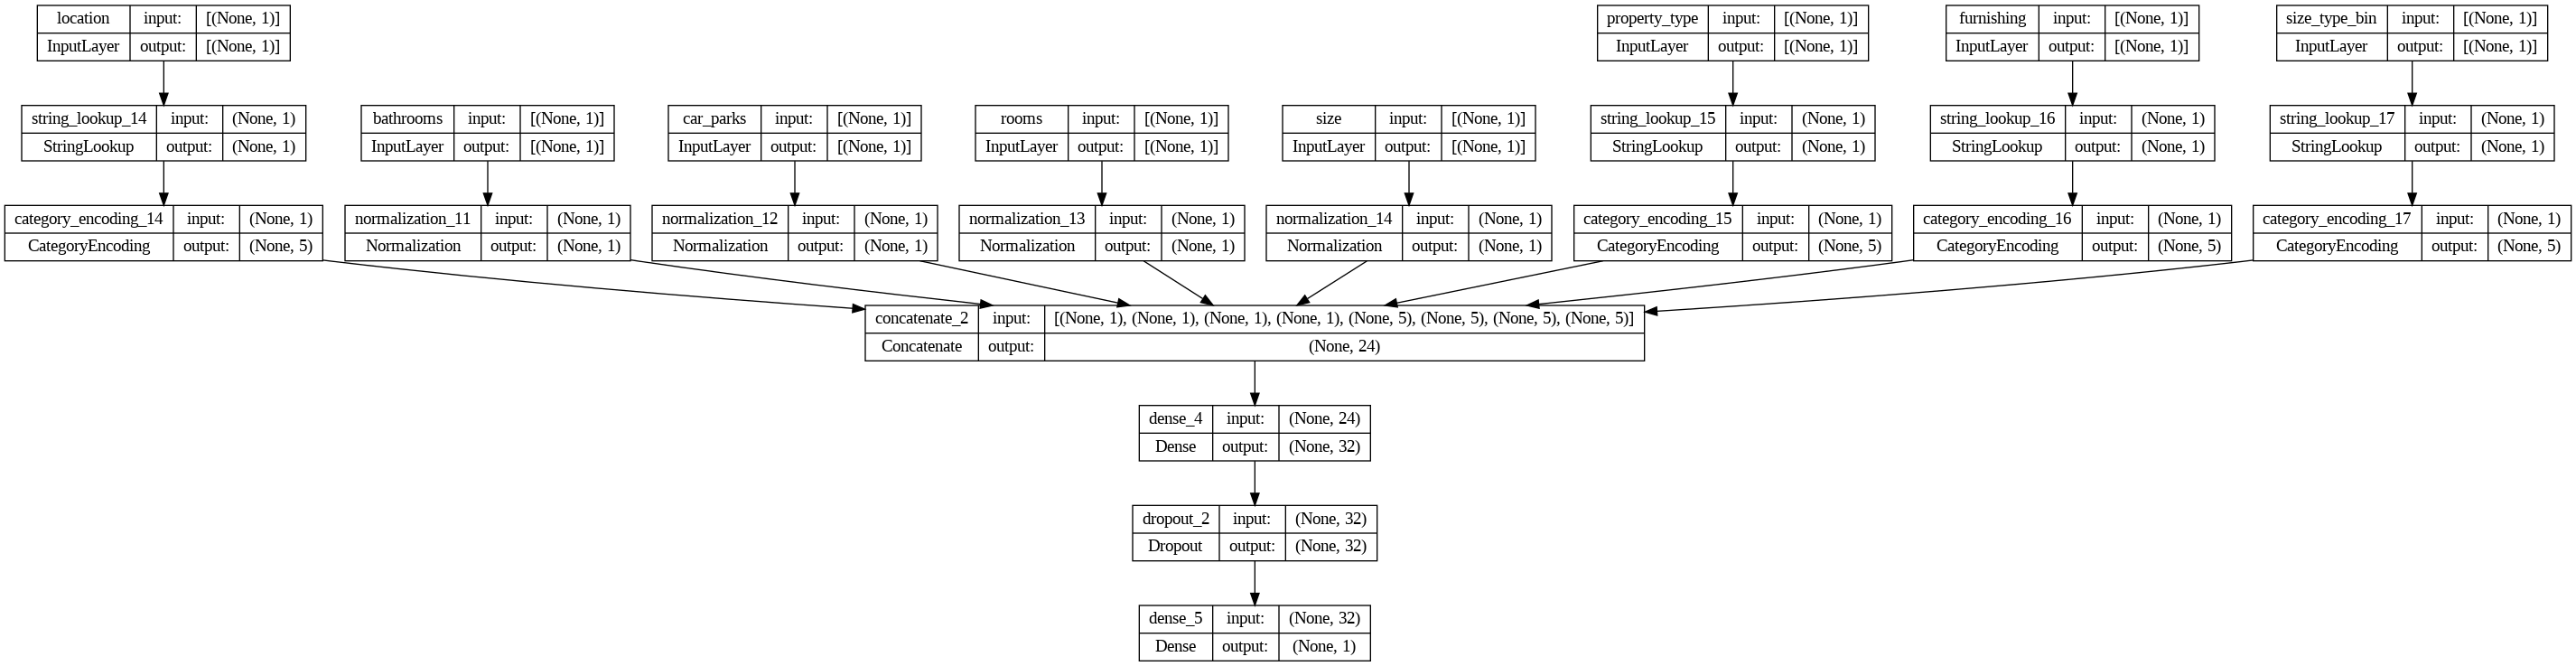

In [109]:
# Use `rankdir='LR'` to make the graph horizontal.
#tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
tf.keras.utils.plot_model(model, show_shapes=True)

In [110]:
# set up early stopping
def set_early_stop(es_monitor, es_mode):
    ''' given monitoring parameter es_monitor and mode es_mode, define early stopping callback, save model callback, and 
    TensorBoard callback
    
    Args:
        es_monitor: the performance parameter to monitor in the callback
        es_mode: the extremity (max or min) to optimize towards
        
    Returns:
        callback_list: list of callback objects
        save_model_path: fully qualified filename to save optimal model to  
    
    
    '''
    # define callback for early stopping
    callback_list = []
    es = EarlyStopping(monitor=es_monitor, mode=es_mode, verbose=1,patience = patience_threshold)
    callback_list.append(es)
    model_path = get_model_path()
    save_model_path = os.path.join(model_path,'scmodel'+modifier+"_"+str(experiment_number))
    # define callback to save best model
    mc = ModelCheckpoint(save_model_path, monitor=es_monitor, mode=es_mode, verbose=1, save_best_only=True, save_format='tf')
    callback_list.append(mc)
    # define callback for TensorBoard
    if tensorboard_callback:
        tensorboard_log_dir = os.path.join(get_path(),"tensorboard_log",datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard = TensorBoard(log_dir= tensorboard_log_dir)
        callback_list.append(tensorboard)
    return(callback_list,save_model_path)

Train the model

In [111]:
#model.fit(train_ds, epochs=config['hyperparameters']['epochs'], validation_data=val_ds)
if config['general']['early_stop']:
   callback_list, save_model_path = set_early_stop(es_monitor, es_mode)
   model.fit(train_ds, epochs=config['hyperparameters']['epochs'], validation_data=val_ds,callbacks=callback_list)
else:
   model.fit(train_ds, epochs=config['hyperparameters']['epochs'], validation_data=val_ds)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['price', 'size_type', 'size_bin', 'target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 0s - loss: 0.6820 - accuracy: 0.5227
Epoch 1: val_accuracy improved from -inf to 0.66918, saving model to /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/models/scmodeljan9_2023_5
33/33 [==============================] - 5s 111ms/step - loss: 0.6801 - accuracy: 0.5265 - val_loss: 0.6117 - val_accuracy: 0.6692
Epoch 2/50
32/33 [============================>.] - ETA: 0s - loss: 0.5636 - accuracy: 0.7376
Epoch 2: val_accuracy improved from 0.66918 to 0.77524, saving model to /content/drive/MyDrive/machine_learning_tabular_book/code/deep_learning_best_practices/models/scmodeljan9_2023_5
33/33 [==============================] - 4s 115ms/step - loss: 0.5622 - accuracy: 0.7389 - val_loss: 0.5174 - val_accuracy: 0.7752
Epoch 3/50
31/33 [===========================>..] - ETA: 0s - loss: 0.4862 - accuracy: 0.7905
Epoch 3: val_accuracy improved from 0.77524 to 0.80199, saving model to /content/drive/MyDrive/machi

In [112]:
loss, accuracy = model.evaluate(test_ds)
print("Test Loss", loss)
print("Test Accuracy", accuracy)

11/11 [==============================] - 0s 8ms/step - loss: 0.2927 - accuracy: 0.8660
Test Loss 0.2926732301712036
Test Accuracy 0.8660244941711426


## Use the trained model to get predictions on new data points

Now that the model has been trained, thanks to the Keras preprocessing layers, we can use it to get predictions for new data points.

We will [save and reload the Keras model](../keras/save_and_load.ipynb) with `Model.save` and `Model.load_model` before doing inference on new data:

In [113]:
model_file_name = os.path.join(get_model_path(),config['file_names']['saved_model'])
model.save(model_file_name)
reloaded_model = tf.keras.models.load_model(model_file_name)

In [114]:
print("categorical columns: ",config['categorical'])
print("continuous columns: ",config['continuous'])

categorical columns:  ['location', 'property_type', 'furnishing', 'size_type_bin']
continuous columns:  ['bathrooms', 'car_parks', 'rooms', 'size']


Use the Keras `Model.predict` method to get predictions on a new data point. Use `tf.convert_to_tensor` on each feature to prepare it to be fed into the trained model to get a prediction.

In [115]:
sample = {
    'location': 'Sentul, Kuala Lumpur',
    'rooms': 3.0,
    'property_type': 'Condominium For Sale',
    'furnishing': 'Partly Furnished',
    'size_type_bin': 'built-up 1',
    'bathrooms': 2.0,
    'car_parks': 0.0,
    'size': 950.0,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This property has a %.1f percent probability of "
    "having a price over the median." % (100 * prob)
)

1/1 [==============================] - 0s 211ms/step
This property has a 17.9 percent probability of having a price over the median.


In [116]:
merged_data['price'].median()

980000.0

In [117]:
# print elapsed time to run the notebook
print("--- %s seconds ---" % (time.time() - start_time))

--- 147.40737891197205 seconds ---
